## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018.inp
Note, lambda value for specie 'NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNOH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HON' is not i

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: True	enable reactions: True	enable dissipated energy: True


## Define ranges

In [4]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [5.0, 200.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[1.0]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [20.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [par.alfa_M],
    # vapour pressure [Pa] - will be calculated from T_inf
    P_v = [par.P_v],
    # dynamic viscosity [Pa*s] - will be calculated from T_inf
    mu_L = [par.mu_L],
    # density [kg/m^3]
    rho_L = [par.rho_L],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-1e5*x for x in [1.5, 4.0]], # pressure amplitude [Pa]
    freq = [5000.0, 50000.0], # frequency [Hz]
    n = [1.0]
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

In [5]:
# create folder for parameter study results:
save_path = 'D:/parameter_studies/Ammonia_from_N2_Bubble/'
file = gd.de.Make_dir(save_path)
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 30    # number os total searches
trial_points = 2000  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gd.rand_point(ranges, ID=i, padding=0.001),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_efficiency = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gd.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gd.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
            best_energy_efficiency = data.energy_efficiency
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gd.de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

index:     1990/2000;   success: True;   runtime:  17.26 [s]   |   R_E= 3.494997e-05;   p_A=-3.818506e+05;   freq= 2.689400e+04;   |   NH3 production:  4.967323e+05 [MJ/kg] (best:  418650.9 [MJ/kg])                                                  
DONE
total time:  1556.82 [s]   ( 0.78 [s/run])


best energy_efficiency:  4.186509e+05 [MJ/kg]
30th energy_efficiency:  4.738069e+05 [MJ/kg]


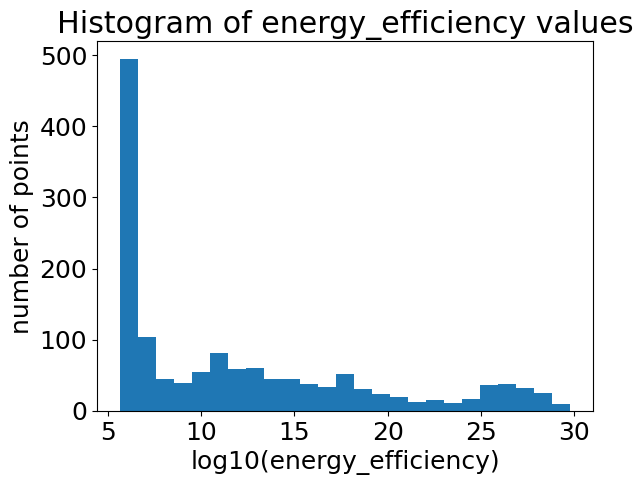

In [6]:

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_efficiency: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_efficiency: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_efficiency)')
plt.ylabel('number of points')
plt.title('Histogram of energy_efficiency values')
plt.show()

In [7]:
ranges2 = gd.de.copy(ranges)
for key in ranges:
    if len(ranges[key]) != 2:
        continue
    
    values = [point[key] for point in start_points[:searches]]
    ranges2[key][0] = min(values)
    ranges2[key][1] = max(values)
    print(f'old {key}: {ranges[key][1]-ranges[key][0]: e}')
    print(f'new {key}: {ranges2[key][1]-ranges2[key][0]: e}')

old R_E:  1.950000e-04
new R_E:  3.931929e-05
old p_A: -2.500000e+05
new p_A:  2.181165e+05
old freq:  4.500000e+04
new freq:  3.339933e+04


In [8]:
ranges2

{'R_E': [5.902004365807957e-06, 4.522129163576335e-05],
 'ratio': [1.0],
 'gases': [[31]],
 'fractions': [[1.0]],
 'P_amb': [101325.0],
 'T_inf': [293.15],
 'alfa_M': [0.35],
 'P_v': [2338.1],
 'mu_L': [0.001],
 'rho_L': [998.2],
 'c_L': [1483.0],
 'surfactant': [1.0],
 'p_A': [-370080.19352207886, -151963.66247259863],
 'freq': [14142.24198685697, 47541.57616101526],
 'n': [1.0]}

In [42]:
kwargs_list = [dict(
    ranges=ranges,
    path=save_path,
    to_optimize=to_optimize,
    start_point=start_point,
    step_limit=100,
    first_step=0.01,
    min_step=10e-5,
    delta=1e-6,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=50,
    Radau_timeout=500,
    ) for start_point in start_points[:searches]]

# Run gradient_search() multithread

In [43]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
gradient descent general settings:
    to_optimize = '{to_optimize}'   # key in data from de.get_data()
    searches = {searches}    # number os total searches
    trial_points = {trial_points}  # number of trial start_points. best ones will be used for searches

ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list[:searches]:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [44]:
"""Gradient descent, multithread"""

best_output = 1.0e30
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=1) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        last_data, best_outputs, elapsed = result
        num += 1
        to_plot.append(best_outputs)
        last_points.append(last_data)
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]
        
        # print stuff:
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps, finished in {elapsed: 8.2f} [s]   ({(elapsed / len(best_outputs)): 4.2f} [s/step]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / searches): .2f} [s/search])')

  1/30: Total 5   steps, finished in   273.91 [s]   ( 54.78 [s/step]).   Final energy_efficiency:  460872.4 (best:  460872.4)
  2/30: Total 4   steps, finished in   313.15 [s]   ( 78.29 [s/step]).   Final energy_efficiency:  460529.6 (best:  460529.6)
  3/30: Total 5   steps, finished in   384.80 [s]   ( 76.96 [s/step]).   Final energy_efficiency:  412965.3 (best:  412965.3)
  4/30: Total 5   steps, finished in   459.25 [s]   ( 91.85 [s/step]).   Final energy_efficiency:  460541.4 (best:  412965.3)
  5/30: Total 6   steps, finished in   487.34 [s]   ( 81.22 [s/step]).   Final energy_efficiency:  416931.9 (best:  412965.3)
  6/30: Total 6   steps, finished in   659.12 [s]   ( 109.85 [s/step]).   Final energy_efficiency:  461746.3 (best:  412965.3)
  7/30: Total 23  steps, finished in  1269.36 [s]   ( 55.19 [s/step]).   Final energy_efficiency:  455893.4 (best:  412965.3)
  8/30: Total 23  steps, finished in  1270.00 [s]   ( 55.22 [s/step]).   Final energy_efficiency:  454678.6 (best:  4

## Plot results

In [19]:
[(len(x), x[-1]) for x in to_plot if x[-1]<1e10]

[(5, 460604.92795150424),
 (7, 460755.12227822986),
 (10, 416662.3176751191),
 (7, 461537.2253275651),
 (17, 460500.5677413998),
 (16, 412445.5601733415),
 (19, 412936.65273018257),
 (21, 415970.2282947424),
 (12, 410975.14793004136),
 (30, 416328.32071900024),
 (17, 465645.1430021489),
 (8, 462312.26287288853),
 (6, 465728.18080176716),
 (35, 411873.77029659576),
 (25, 460025.8031459351),
 (43, 411913.68484957033),
 (50, 410618.3818322805),
 (47, 414068.82621379854),
 (13, 410676.65733023104),
 (30, 412152.8927285969),
 (26, 412363.47076306044),
 (25, 461791.92801245814),
 (18, 463924.429283777),
 (51, 417810.1470364596),
 (53, 417651.0655116842),
 (78, 410633.3990212184),
 (100, 410625.98423307063),
 (51, 459913.8613881737),
 (66, 461547.16848765383)]

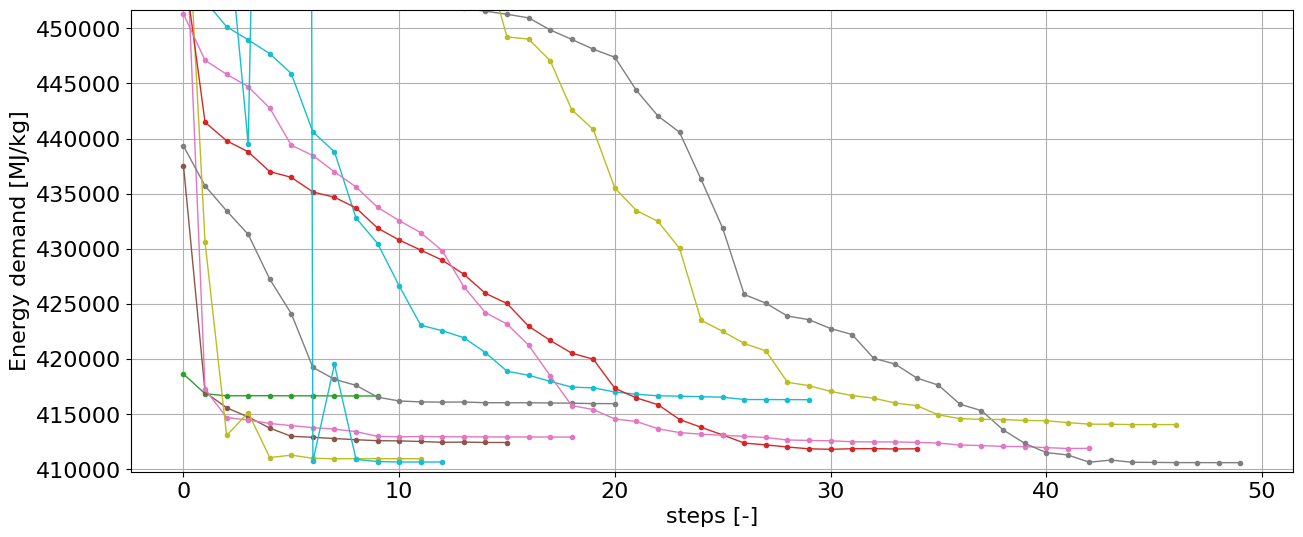

In [20]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[:20]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
#fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'Energy demand [MJ/kg]')
ax.set_ylim(0.998*best_output, 1.1*best_output)
#ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()
fig.savefig('images/convergence.png', bbox_inches='tight')

In [39]:
# remove 14th element of last_points, last_values and to_plot
last_points2 = []
for i, last_point in enumerate(last_points):
    if i != 14:
        last_points2.append(last_point)


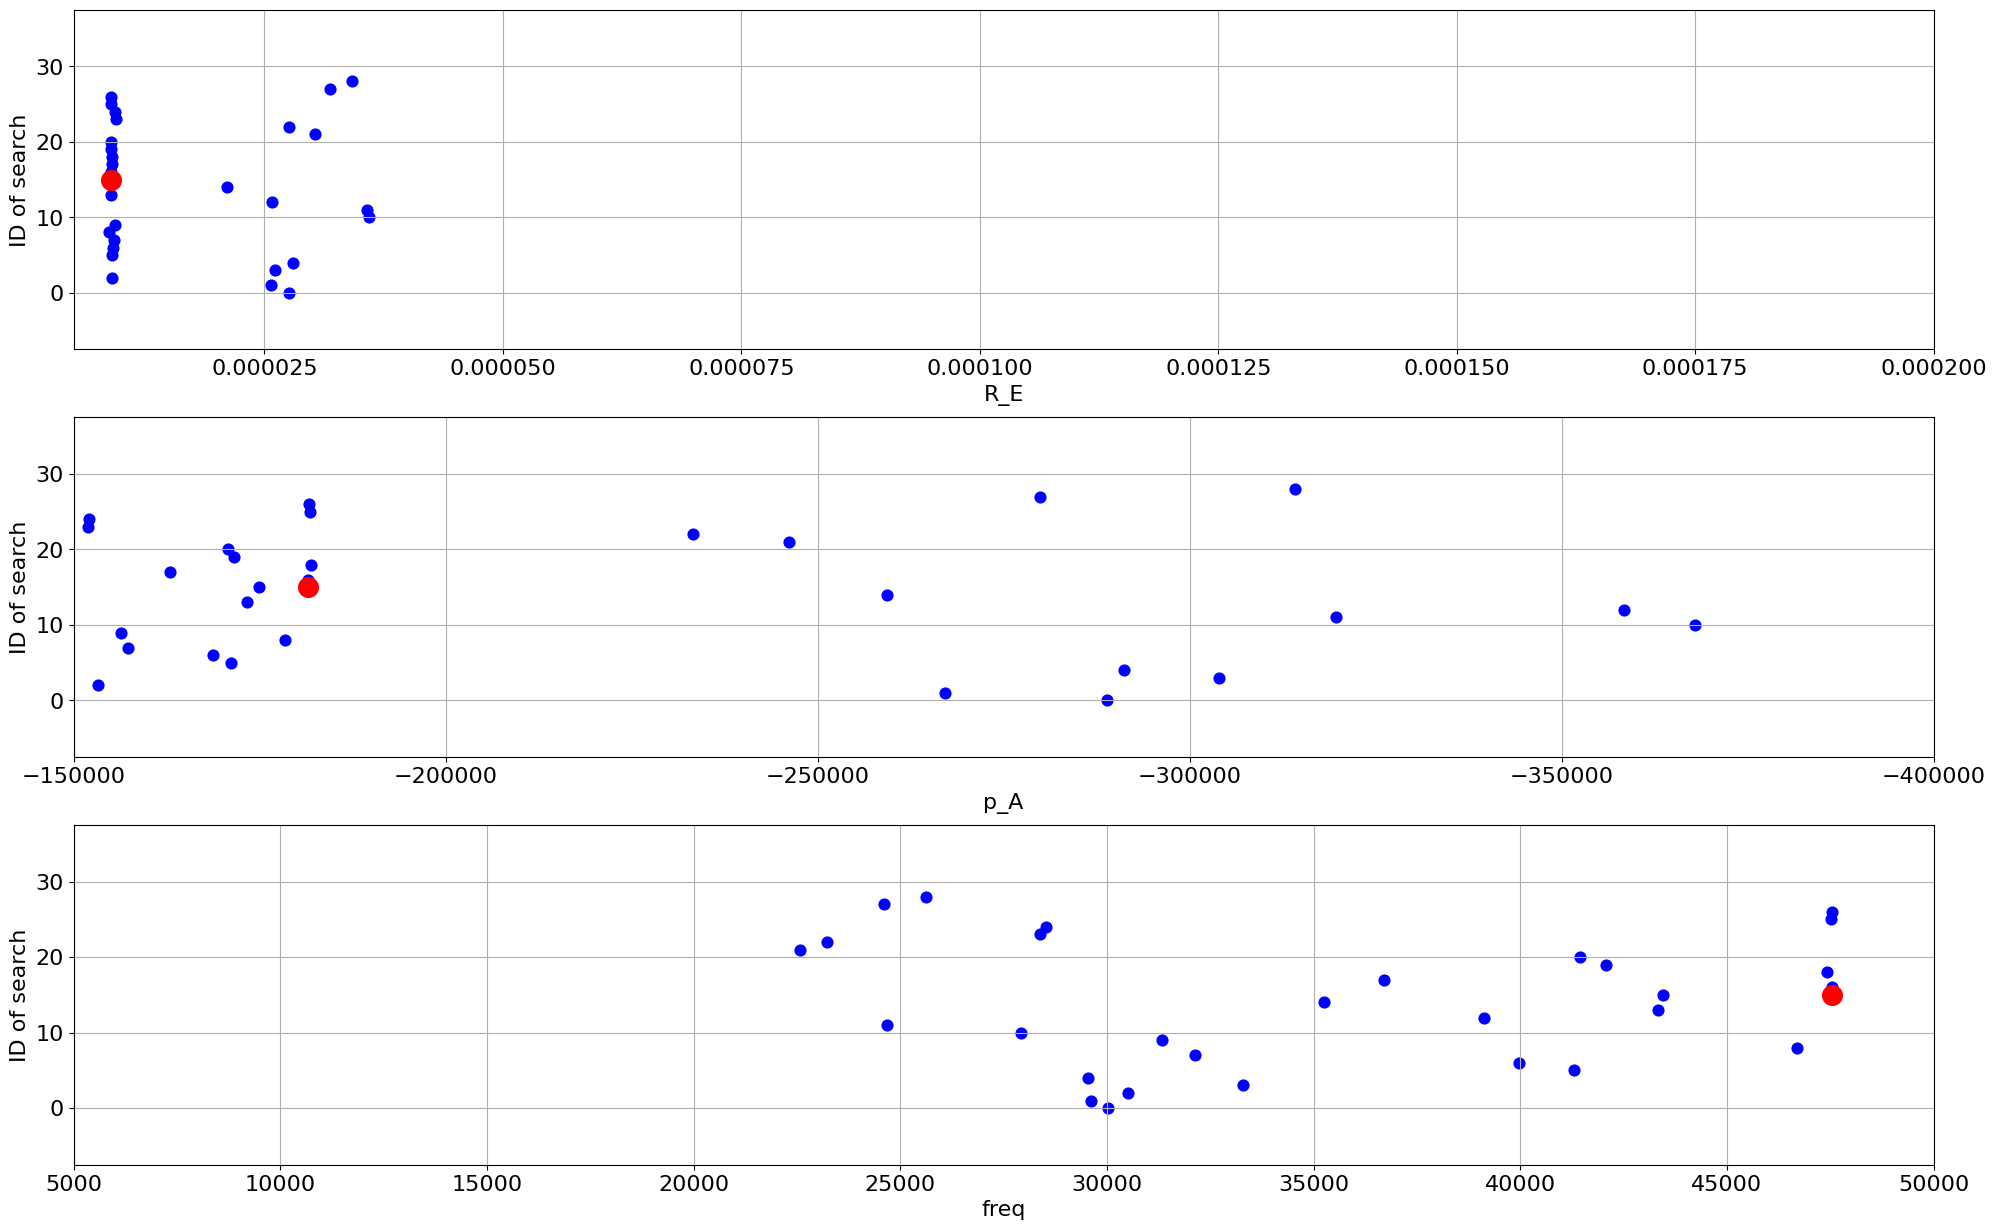

In [41]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points2]
    y = [i for i, last_point in enumerate(last_points2)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
